
=== Best Government Policy ===
Carbon Tax: $106.67/ton, Subsidy: $3.50/gal
Welfare: 5.087166 billion $
Total emissions (tons): 6.218894e+06
Equilibrium alphas and per-airline profits:
  AeroLink   α=0.862, Profit=6.494 billion $
  SkyIndia   α=0.966, Profit=6.081 billion $
  BlueJet    α=1.000, Profit=6.062 billion $
Prices at equilibrium: p_conv=$0.01/gal, p_saf=$3.49/gal
Total SAF demand = 1.396B gal, Conv = 0.099B gal

Saved top candidate policies to: ./top_government_policies_tuned.csv
Saved welfare heatmap to: ./welfare_heatmap_tuned.png


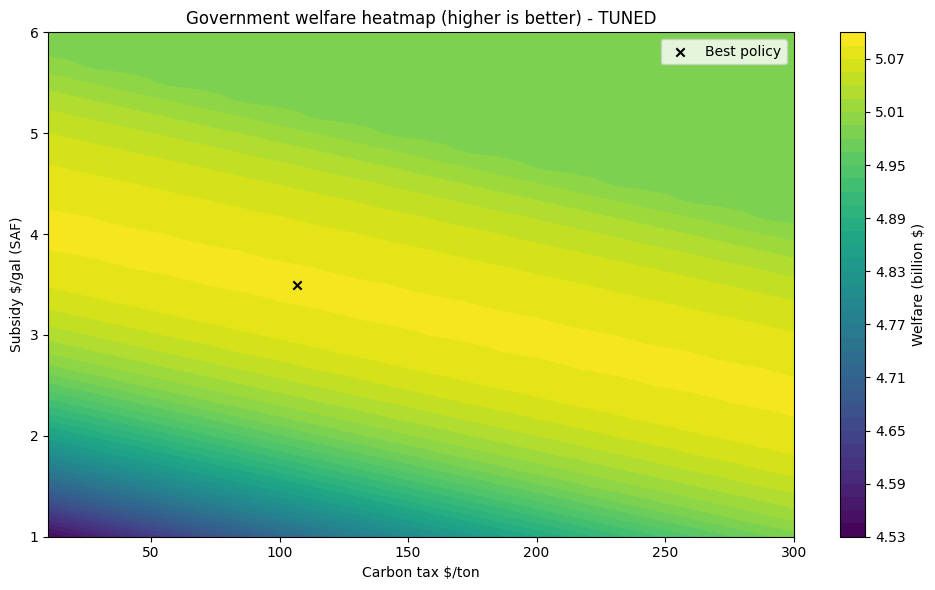

In [11]:
"""
stackelberg_nash_multi_airline_tuned.py

Multi-airline Stackelberg–Nash simulation with tuned parameters so government
is more likely to choose positive carbon tax and/or subsidy.

Run:
    python stackelberg_nash_multi_airline_tuned.py
Dependencies:
    numpy, scipy, matplotlib, pandas
"""
import os
import numpy as np
from math import tanh
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import pandas as pd

# ------------------ Emission factors ------------------
def emissions_aviation_fuel():
    return 9.5  # kg CO2 per gallon

def emissions_saf():
    return 3.78  # kg CO2 per gallon

# ------------------ Price functions (TUNED) ------------------
def aviation_fuel_price(q_conv_b_total):
    """
    Conventional fuel price $/gal as function of total conventional quantity (billion gal).
    Small floor applied to avoid exact zero prices from extreme elasticities.
    """
    p0 = 2.10
    q0 = 1.495
    elasticity = 0.1
    q = max(q_conv_b_total, 1e-9)
    raw = p0 * (q / q0)**(1.0 / elasticity)
    # price floor to avoid pathological zeros in extreme cases
    return max(raw, 0.01)

def saf_price(q_saf_b_total):
    """
    TUNED: SAF is made more viable (lower base price and lower elasticity).
    """
    p0 = 4.0       # TUNED: was 6.3
    q0 = 1.495
    elasticity = 0.5  # TUNED: was 0.8 (less elastic => price rises slower)
    q = max(q_saf_b_total, 1e-9)
    raw = p0 * (q / q0)**(1.0 / elasticity)
    return max(raw, 0.01)

# ------------------ Heterogeneous company parameters ------------------
company_names = ["AeroLink", "SkyIndia", "BlueJet"]
# per-company base revenue (billion $)
base_revenues = np.array([10.0, 9.0, 8.7])
# per-company operating costs (billion $)
operating_costs = np.array([5.8, 5.4, 5.2])
# per-company baseline fuel demand (billion gallons)
q_baselines = np.array([0.6, 0.5, 0.395])  # sum ~1.495

# ------------------ Revenue function (TUNED) ------------------
def revenue(alpha, base_revenue):
    """
    TUNED: stronger reward for SAF adoption (brand/price premium for greener operations)
    multiplier increased from 1.3 -> 3.0
    """
    return base_revenue + 3.0 * np.tanh(1.5 * alpha)  # TUNED multiplier

# ------------------ Per-airline profit ------------------
def airline_profit(alpha_i, i, alphas_other, subsidy_per_gal, carbon_tax_per_ton):
    alphas = np.array(alphas_other, copy=True)
    alphas[i] = alpha_i # need to check this
    q = np.array(q_baselines)
    q_saf = q * alphas
    q_conv = q * (1 - alphas)

    Q_saf_total = q_saf.sum()
    Q_conv_total = q_conv.sum()
    p_conv = aviation_fuel_price(Q_conv_total)
    p_saf = saf_price(Q_saf_total)

    # fuel cost for airline i (in billion $)
    fuel_cost_i_b = p_conv * q_conv[i] + p_saf * q_saf[i]
    # carbon tax (billion $)
    tau = carbon_tax_per_ton
    carbon_tax_i_b = tau * (emissions_aviation_fuel() * q_conv[i] + emissions_saf() * q_saf[i]) / 1000.0
    # subsidy income (billion $)
    subsidy_income_i_b = subsidy_per_gal * q_saf[i]

    profit_i_b = revenue(alpha_i, base_revenues[i]) - operating_costs[i] - fuel_cost_i_b - carbon_tax_i_b + subsidy_income_i_b
    return profit_i_b

# ------------------ Compute totals and profits ------------------
def compute_all_profits(alphas, subsidy_per_gal, carbon_tax_per_ton):
    q = np.array(q_baselines)
    alphas = np.array(alphas)
    q_saf = q * alphas
    q_conv = q * (1 - alphas)

    Q_saf_total = q_saf.sum()
    Q_conv_total = q_conv.sum()
    p_conv = aviation_fuel_price(Q_conv_total)
    p_saf = saf_price(Q_saf_total)

    profits = []
    for i in range(len(q)):
        fuel_cost_i_b = p_conv * q_conv[i] + p_saf * q_saf[i]
        carbon_tax_i_b = carbon_tax_per_ton * (emissions_aviation_fuel() * q_conv[i] + emissions_saf() * q_saf[i]) / 1000.0
        subsidy_income_i_b = subsidy_per_gal * q_saf[i]
        profit_i_b = revenue(alphas[i], base_revenues[i]) - operating_costs[i] - fuel_cost_i_b - carbon_tax_i_b + subsidy_income_i_b
        profits.append(profit_i_b)
    profits = np.array(profits)

    totals = {
        'p_conv_per_gal': p_conv,
        'p_saf_per_gal': p_saf,
        'Q_conv_total_billion': Q_conv_total,
        'Q_saf_total_billion': Q_saf_total,
        'profits_billion_each': profits,
        'profit_total_billion': profits.sum(),
        'subsidy_budget_billion': subsidy_per_gal * Q_saf_total,
        'carbon_tax_revenue_billion': carbon_tax_per_ton * (emissions_aviation_fuel() * Q_conv_total + emissions_saf() * Q_saf_total) / 1000.0
    }
    return totals

# ------------------ Nash solver (iterative best-response) ------------------
def find_nash_equilibrium(subsidy_per_gal, carbon_tax_per_ton, tol=1e-6, max_iters=3000, verbose=False):
    n = len(q_baselines)
    # Start from moderate SAF shares to help convergence (not all zeros)
    alphas = np.array([0.2]*n)
    for it in range(max_iters):
        max_change = 0.0
        for i in range(n):
            # best response for airline i
            def neg_profit(ai):
                return -airline_profit(ai, i, alphas, subsidy_per_gal, carbon_tax_per_ton)
            res = minimize_scalar(neg_profit, bounds=(0.0, 1.0), method='bounded', options={'xatol':1e-6})
            new_ai = float(res.x)
            change = abs(new_ai - alphas[i])
            if change > max_change:
                max_change = change
            alphas[i] = new_ai
        if verbose:
            print(f"Iter {it}: max_change={max_change:.6g}, alphas={alphas}")
        if max_change < tol:
            break
    totals = compute_all_profits(alphas, subsidy_per_gal, carbon_tax_per_ton)
    return alphas, totals

# ------------------ Social welfare (TUNED SCC default) ------------------
def social_welfare(alphas, totals, social_cost_co2_per_ton=1500.0):
    """
    Welfare = sum of airline profits + carbon tax revenue - subsidy payments - SCC*emissions
    TUNED: default SCC = $200/ton (was 50). Increase this to push govt to internalize CO2.
    """
    Q_conv = totals['Q_conv_total_billion']
    Q_saf = totals['Q_saf_total_billion']
    E_kg = emissions_aviation_fuel() * Q_conv * 1e9 + emissions_saf() * Q_saf * 1e9
    E_tons = E_kg / 1000.0
    tax_revenue_b = totals['carbon_tax_revenue_billion']
    subsidy_b = totals['subsidy_budget_billion']
    welfare_billion = totals['profit_total_billion'] + tax_revenue_b - subsidy_b - (social_cost_co2_per_ton * E_tons)/1e9
    return welfare_billion, E_tons

# ------------------ Government grid search ------------------
def government_optimize(tau_range=(10, 300.0), s_range=(1.0, 6.0), social_cost_co2_per_ton=1500.0, tau_steps=31, s_steps=31, verbose=False):
    tau_grid = np.linspace(tau_range[0], tau_range[1], tau_steps)
    s_grid = np.linspace(s_range[0], s_range[1], s_steps)
    best = {'welfare': -1e18}
    history = []
    for tau in tau_grid:
        for s in s_grid:
            alphas, totals = find_nash_equilibrium(s, tau)
            welfare_b, E_tons = social_welfare(alphas, totals, social_cost_co2_per_ton)
            history.append({'tau':tau, 's':s, 'welfare_billion':welfare_b, 'E_tons':E_tons, 'alphas':alphas.copy(), 'totals':totals.copy()})
            if welfare_b > best['welfare']:
                best = {'tau':tau, 's':s, 'welfare':welfare_b, 'E_tons':E_tons, 'alphas':alphas.copy(), 'totals':totals.copy()}
            if verbose and ((s == s_grid[0] and tau % max(1, tau_grid.size//5) == 0) or (tau == tau_grid[0] and s % max(1, s_grid.size//5) == 0)):
                print(f"tau={tau:.1f} s={s:.2f} -> welfare {welfare_b:.6f}")
    history_df = pd.DataFrame([{k:v for k,v in h.items() if k not in ['alphas','totals']} for h in history])
    return best, history, history_df

# ------------------ Main demo ------------------
def main():
    # Government search domain (tuned)
    tau_range = (10, 300.0)   # $/ton
    s_range = (1.0, 6.0)       # $/gal subsidy

    # Run government optimization (finer grid)
    best, history, history_df = government_optimize(tau_range=tau_range, s_range=s_range,
                                                    social_cost_co2_per_ton=1500.0,
                                                    tau_steps=31, s_steps=31, verbose=False)

    print("\n=== Best Government Policy ===")
    print(f"Carbon Tax: ${best['tau']:.2f}/ton, Subsidy: ${best['s']:.2f}/gal")
    print(f"Welfare: {best['welfare']:.6f} billion $")
    print(f"Total emissions (tons): {best['E_tons']:.6e}")
    print("Equilibrium alphas and per-airline profits:")
    for name, alpha, profit in zip(company_names, best['alphas'], best['totals']['profits_billion_each']):
        print(f"  {name:10s} α={alpha:.3f}, Profit={profit:.3f} billion $")
    print("Prices at equilibrium: p_conv=${:.2f}/gal, p_saf=${:.2f}/gal".format(best['totals']['p_conv_per_gal'], best['totals']['p_saf_per_gal']))
    print("Total SAF demand = {:.3f}B gal, Conv = {:.3f}B gal".format(best['totals']['Q_saf_total_billion'], best['totals']['Q_conv_total_billion']))

    # Save top policies table
    history_sorted = sorted(history, key=lambda x: -x['welfare_billion'])
    topk = history_sorted[:10]
    rows = []
    for h in topk:
        rows.append({
            'tau': h['tau'],
            's': h['s'],
            'welfare_billion': h['welfare_billion'],
            'alphas': list(h['alphas']),
            'profit_total_billion': h['totals']['profit_total_billion'],
            'p_conv': h['totals']['p_conv_per_gal'],
            'p_saf': h['totals']['p_saf_per_gal'],
            'E_tons': h['E_tons']
        })
    df_top = pd.DataFrame(rows)
    out_csv = os.path.join('.', 'top_government_policies_tuned.csv')
    df_top.to_csv(out_csv, index=False)
    print(f"\nSaved top candidate policies to: {out_csv}")

    # Welfare heatmap
    taus = sorted(list({h['tau'] for h in history}))
    ss = sorted(list({h['s'] for h in history}))
    W = np.zeros((len(ss), len(taus)))
    for h in history:
        i = ss.index(h['s'])
        j = taus.index(h['tau'])
        W[i,j] = h['welfare_billion']

    plt.figure(figsize=(10,6))
    X, Y = np.meshgrid(taus, ss)
    cf = plt.contourf(X, Y, W, levels=40)
    plt.xlabel('Carbon tax $/ton')
    plt.ylabel('Subsidy $/gal (SAF)')
    plt.title('Government welfare heatmap (higher is better) - TUNED')
    plt.colorbar(cf, label='Welfare (billion $)')
    plt.scatter([best['tau']], [best['s']], marker='x', color='k', label='Best policy')
    plt.legend()
    out_png = os.path.join('.', 'welfare_heatmap_tuned.png')
    plt.tight_layout()
    plt.savefig(out_png, dpi=220)
    print(f"Saved welfare heatmap to: {out_png}")
    plt.show()

if __name__ == '__main__':
    main()
